# Classification on Nursery Dataset
This notebook demonstrates model diagnostics on the nursersy dataset https://www.openml.org/d/43938.

The modelling goal is to predict the expectation $E(Y|X)$ of 
$$
Y
= 
\begin{cases}
1 \text{ if class = "priority" }\\
0 \text{ if otherwise }
\end{cases}
$$

conditional on the features $X$.

The impatient can directly jump to chapters 3-4 where the capability of `model-diagnostics` are shown.
Chapters 1-2 are needed for data preparation and model training.

## 1. Data
### 1.1 Data Load and Preprocessing

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
X, y = fetch_openml(data_id=43938, as_frame=True, return_X_y=True, parser="auto")
df_original = pd.concat([X, y], axis=1)

In [3]:
df = df_original.query("`class` != 'recommend'").copy()
df['count'] = 1
df['class'] = df['class'].cat.remove_unused_categories()
df['binary_response'] = (df['class'] == 'priority')
y_var = 'binary_response'
x_vars = X.columns
print(f"The prepared dataset contains {df.shape[0]} rows.")

The prepared dataset contains 12958 rows.


In [4]:
df.head()

,parents,has_nurs,form,children,housing,finance,social,health,class,count,binary_response
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority,1,True
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom,1,False
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority,1,True
5,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom,1,False
6,usual,proper,complete,1,convenient,convenient,problematic,recommended,priority,1,True


### 1.2 Data Split

In [5]:
df_train, df_test = train_test_split(df, train_size=0.75, random_state=1234321)
df = (
    pd.concat((df_train, df_test), axis=0, keys=("train", "test"))
    .reset_index(level=0)
    .rename(columns={"level_0": "split"})
)

y_train, y_test = df_train[y_var], df_test[y_var]
X_train, X_test = df_train[x_vars], df_test[x_vars]

We check whether the split results in two approximately identically distributed samples.

In [6]:
count_by_split = df.groupby("split").apply(len)
grouper = df.groupby(["split", y_var])

(df.groupby(["split", y_var]).apply(lambda x: x['count'].sum())
 / count_by_split).unstack(y_var)

binary_response,False,True
split,,
test,0.673457,0.326543
train,0.669891,0.330109


## 2. Models
We aim at predicting the conditional expectation $E(Y|X)$ and will finally evaluate the models with the log loss $$S(y, z) = -ylog(z) - (1 - y) log (1 - z)$$
### 2.1 The trivial model

In [7]:
from sklearn.dummy import DummyClassifier


m_trivial = DummyClassifier(strategy="prior").fit(X_train, y_train)

### 2.2 Logistic

Here, we train a Logistic Regression model.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


x_discrete = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance',
              'social', 'health']
# ColumnTransformer for linear models
col_trans_cat = ColumnTransformer(
    [
        (
            "categorical_features",
            OneHotEncoder(drop="first", sparse_output=False),
            x_discrete
        ),
    ]
)
m_logistic = Pipeline(
    [
        ("column_transformer", col_trans_cat),
        (
            "model",
            LogisticRegression(max_iter=10000
                               )
        ),
    ]
).fit(X_train, y_train)

We can have a look at the model coefficients

In [9]:
feature_names = m_logistic[:-1].get_feature_names_out()
model_coefs = m_logistic.steps[-1][1].coef_.flatten()
model_coefs = pd.Series(model_coefs, feature_names).sort_values()
with pd.option_context('display.max_rows', 8):
    display(model_coefs)

categorical_features__has_nurs_very_crit     -1.172242
categorical_features__housing_critical       -0.810311
categorical_features__children_3             -0.697852
categorical_features__children_more          -0.671909
                                                ...   
categorical_features__has_nurs_proper         2.825156
categorical_features__has_nurs_less_proper    2.840361
categorical_features__health_priority         6.393581
categorical_features__health_recommended      7.253887
Length: 19, dtype: float64

### 2.4 Gradient Boosted Decision Trees
We will now train a `HistGradientBoostingClassifier`.

In [10]:
%%time
# Note that this cell might take a little while.
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier



col_trans_bt = ColumnTransformer(
    [
        ("categorical_features", OrdinalEncoder(), x_discrete),
    ]
)
m_hgbt_base = Pipeline(
    [
        ("column_transformer", col_trans_bt),
        (
            "model", HistGradientBoostingClassifier(
                loss="log_loss",
                categorical_features=list(range(len(x_discrete))),
                max_iter=200,
                random_state=33,
            )
        ),
    ]
)

param_grid = {
    "model__learning_rate": [0.02, 0.05],
    "model__l2_regularization": [0.1, 0.2, 0.3, 1],
    "model__max_depth": [None, 1, 2, 3, 5],
    "model__max_leaf_nodes": [3, 10, 30, 50]
}


# successive halfing grid search (CV) on the training data
shgs = HalvingGridSearchCV(
    m_hgbt_base,
    param_grid=param_grid,
    cv=5,
    scoring="neg_log_loss",
    random_state=321,
).fit(X_train, y_train)

m_hgbt = shgs.best_estimator_

In [ ]:
shgs.best_params_, shgs.best_score_

({'model__l2_regularization': 0.1,
  'model__learning_rate': 0.05,
  'model__max_depth': None,
  'model__max_leaf_nodes': 50},
 -0.012953509513355315)

In [ ]:
m_hgbt[-1].n_iter_

200

## 3. Calibration Assessment
To make the code easier, we put together the predictions of all of our models on the test set in a single dataframe.

In [ ]:
def _helper(mod, X): return pd.Series(mod.predict_proba(X)[:, 1])
models = [m_trivial, m_logistic, m_hgbt]
df_pred_test = pd.concat([_helper(el, X_test) for el in models], axis=1, keys=['Trivial', 'Logistic', 'HGBT'])


## 3.1. Reliability Diagrams
A reliability diagram plots an estimation of $E(Y|m(X))$ versus $m(X)$ and therefore assesses auto-calibration.
Good auto-calibration is seen by closeness to the diagonal depicted as dotted line.

A good way to estimate $E(Y|m(X))$ and thereby avoiding manual binning is by isotonic regression.
This is implemented in `plot_reliability_diagram`.

In [ ]:
import matplotlib.pyplot as plt
from model_diagnostics.calibration import compute_bias, plot_bias, plot_reliability_diagram

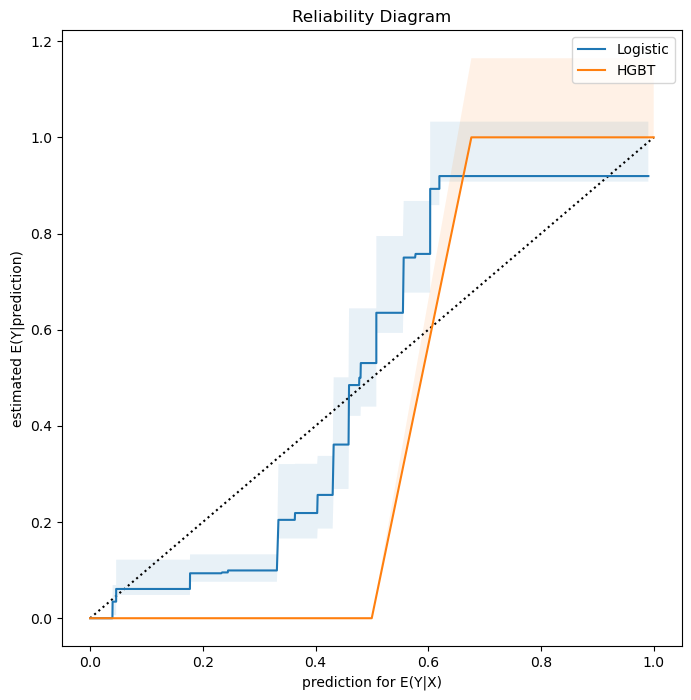

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_reliability_diagram(
    y_obs=y_test,
    y_pred=df_pred_test[['Logistic', 'HGBT']],
    n_bootstrap=100,
    ax=ax,
);

For a better visual comparison, we use the `diagram_type="bias"` option to rotate the plots by 45 degrees (and mirror on the horizontal line) and plot all models in one go.
This means, closer to y=0 is better.
On top, we set the x-axis to a logarithmic scale and zoom in a little.

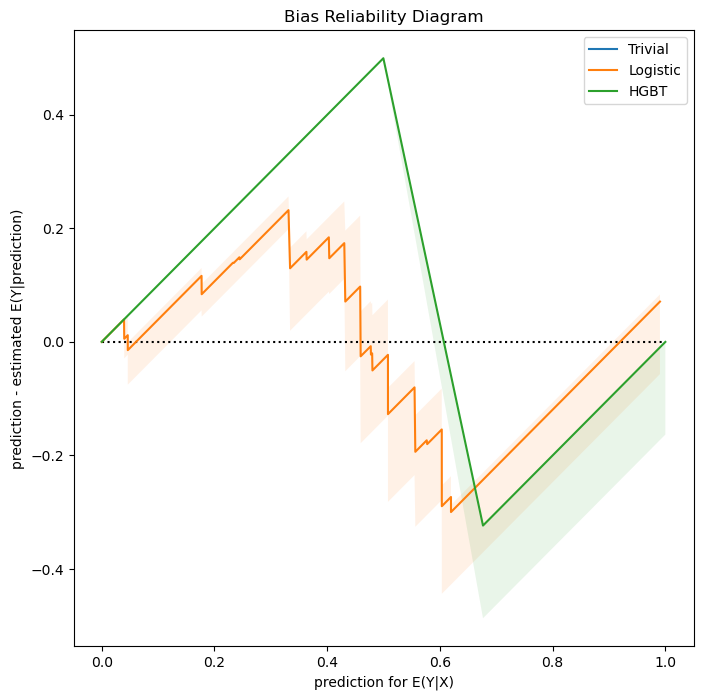

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_reliability_diagram(
    y_obs=y_test,
    y_pred=df_pred_test,
    n_bootstrap=100,
    diagram_type="bias",
    ax=ax
);

### 3.2 Conditional Bias
#### Unconditional Bias

In [ ]:
compute_bias(
    y_obs=y_test,
    y_pred=df_pred_test,
    feature=None,
)

model,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,f64,u32,f64,f64,f64
"""Trivial""",0.003566,3240,3240.0,0.00824,0.665219
"""Logistic""",-0.003882,3240,3240.0,0.004882,0.426503
"""HGBT""",0.000127,3240,3240.0,0.000606,0.833882


#### Bias Conditional on parents

In [ ]:
compute_bias(
    y_obs=y_test,
    y_pred=df_pred_test,
    feature=X_test["parents"],
)

model,parents,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,cat,f64,u32,f64,f64,f64
"""Trivial""","""great_pret""",0.125789,1111,1111.0,0.012102,3.2720e-24
"""Trivial""","""pretentious""",0.006933,1083,1083.0,0.014218,0.625935
"""Trivial""","""usual""",-0.129738,1046,1046.0,0.015417,1.2782e-16
"""Logistic""","""great_pret""",-0.005925,1111,1111.0,0.008313,0.476137
"""Logistic""","""pretentious""",0.005002,1083,1083.0,0.008145,0.539274
"""Logistic""","""usual""",-0.010911,1046,1046.0,0.00892,0.221547
"""HGBT""","""great_pret""",0.000288,1111,1111.0,0.000718,0.688596
"""HGBT""","""pretentious""",0.00056,1083,1083.0,0.000911,0.538871
"""HGBT""","""usual""",-0.000492,1046,1046.0,0.001432,0.731426


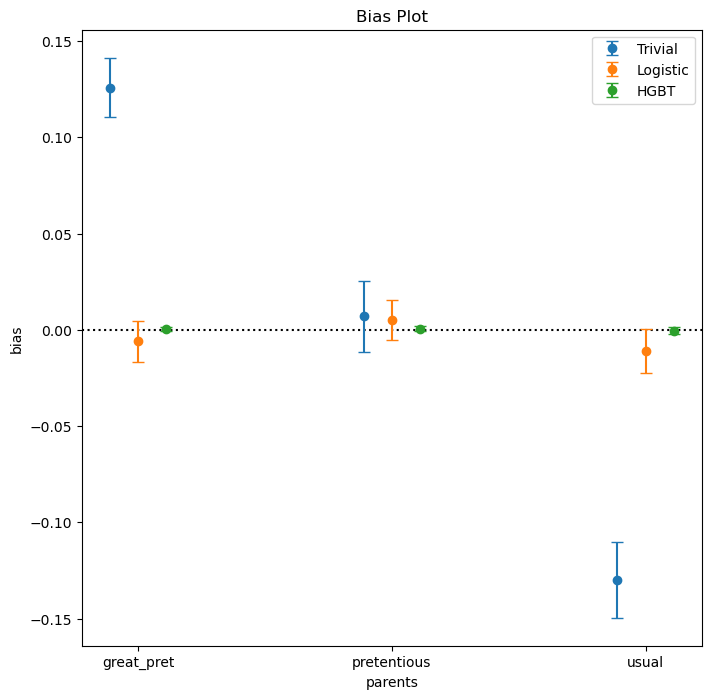

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_bias(
    y_obs=y_test,
    y_pred=df_pred_test,
    feature=X_test["parents"],
    confidence_level=0.8
);

## 4. Predictive Model Performance
### 4.1 Score Decomposition of the Gamma Deviance
We use the [log loss](https://lorentzenchr.github.io/model-diagnostics/reference/model_diagnostics/scoring/scoring/#model_diagnostics.scoring.scoring.LogLoss) and evaluate on the test set.
On top, we additively decompose the scores in terms of miscalibration (smaller is better), discrimination (larger is better) and uncertainty (property of the data, same for all models).

In [ ]:
from model_diagnostics.scoring import LogLoss, decompose


log_loss = LogLoss()

df = decompose(
    y_obs=y_test,
    y_pred=df_pred_test,
    scoring_function=log_loss,
)
df.sort(["score"])

model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""HGBT""",0.010746,0.631704,0.631704,0.010746
"""Logistic""",0.065348,0.422935,0.631704,0.274117
"""Trivial""",0.000029,0.0,0.631704,0.631732


First, the HGBT model has the best (smallest) log loss in column **score**.
We also see that the uncertainty term is model independent as it is a property of the data and the scoring function only.

The HGBT model is superior compared to the logistic model both in terms of the **miscalibration** (lower) and of the **discrimination** (higher).

### 4.2 Murphy Diagram
How does the ranking of the model performances change with other scoring functions?
Is one model dominating the others for a wide range of scoring functions?
Such questions can be handily answered by a Murphy diagram.
It plots the mean score for a wide range of elementary scoring functions, parametrized by `eta` on the x-axis.
We explicitly specify the `etas` to zoom into the range where differences can be spotted.

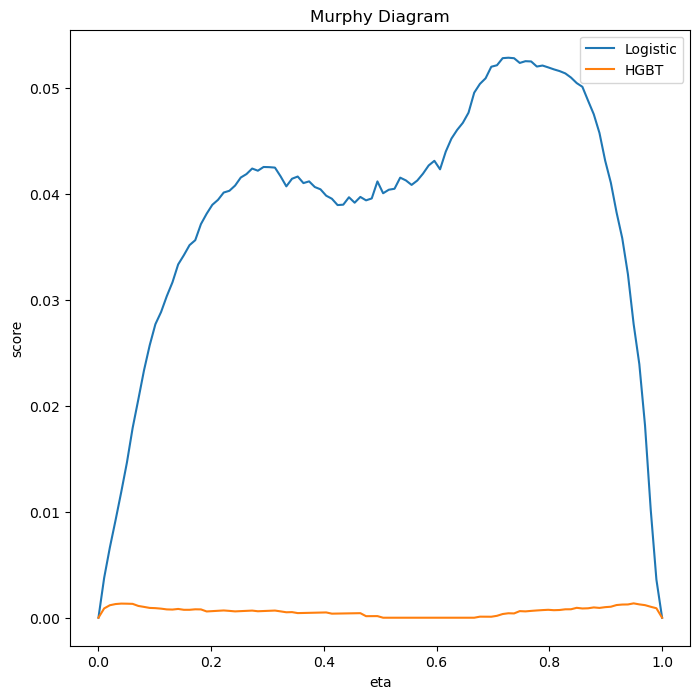

In [ ]:
from model_diagnostics.scoring import SquaredError, plot_murphy_diagram

fig, ax = plt.subplots(figsize=(8, 8))
plot_murphy_diagram(
    y_obs=y_test,
    y_pred=df_pred_test.loc[:, ['Logistic', 'HGBT']],
    etas=100,
);

The HGBT model has the best performance, also when measured with the squared error

In [ ]:
decompose(
    y_obs=y_test,
    y_pred=df_pred_test,
    scoring_function=SquaredError(),
).sort(["score"])

model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""HGBT""",0.001188,0.219913,0.219913,0.001188
"""Logistic""",0.016174,0.158884,0.219913,0.077203
"""Trivial""",0.000013,0.0,0.219913,0.219925
